本笔记本演示了如何利用 GPT 的视觉能力处理视频。GPT-4o 并不直接接受视频作为输入，但我们可以结合视觉功能和 128K 上下文窗口，一次性描述整个视频的静态帧。我们将通过两个示例进行讲解：
- 使用 GPT-4o 获取视频描述
- 使用 GPT-o 和 TTS API 为视频生成配音

In [ ]:
%pip install cv2
%pip install opencv-python

In [4]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI()

# 利用GPT的视觉能力获取视频描述

首先，我们使用 OpenCV 从包含野牛和狼的自然视频中提取帧：

618 frames read.


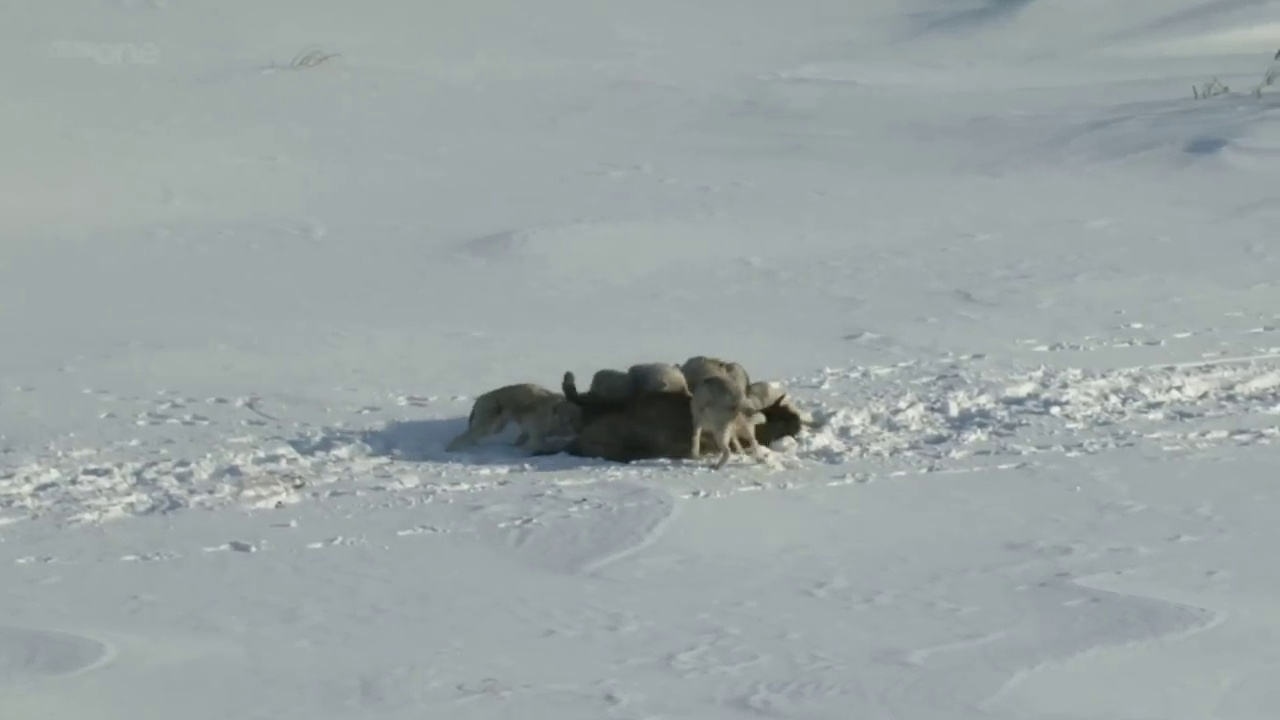

In [5]:
# 初始化VideoCapture对象，用于从视频文件中捕获视频流
video = cv2.VideoCapture("./archive/bison.mp4")

# 创建一个列表，用于存储每帧图像的Base64编码字符串
base64Frames = []
# 检查视频是否成功打开，进入循环读取视频帧
while video.isOpened():
    # 读取视频的下一帧，success表示是否成功读取，frame为图像帧
    success, frame = video.read()
    # 如果无法成功读取帧，则退出循环
    if not success:
        break
    # 将图像帧转换为JPEG格式，并存储为二进制数据
    _, buffer = cv2.imencode(".jpg", frame)
    # 将二进制数据转换为Base64编码，并添加到列表中
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

# 释放VideoCapture对象，关闭视频文件
video.release()

# 打印读取的帧数，用于调试和确认视频读取的完整性
print(len(base64Frames), "frames read.")

# 创建一个显示句柄，用于在Jupyter Notebook中动态显示图像
display_handle = display(None, display_id=True)
# 遍历Base64编码的图像帧，动态更新显示
for img in base64Frames:
    # 将Base64编码的图像数据解码为二进制，更新显示句柄
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    # 短暂休眠，以便于动态显示图像序列
    time.sleep(0.025)

一旦我们获取了视频帧，我们便构建提示并发送请求至 GPT（注意，我们无需发送每一帧 GPT 就能理解发生了什么）：

In [6]:
# 定义一个列表 PROMPT_MESSAGES，用于存储用户的提示信息
PROMPT_MESSAGES = [
    {
        # 定义字典，包含角色和内容
        "role": "user",
        "content": [
            "这些是我想上传的视频中的帧。生成一个引人注目的描述，我可以和视频一起上传。",
            # 使用 map 函数和 lambda 表达式，将 base64Frames 列表中的每第 50 个元素转换为字典，并添加到 content 列表中
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]

params = {
    "model": "gpt-4o-mini",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)

print(result)

print(result.choices[0].message.content)

ChatCompletion(id='chatcmpl-9wOp8Jnx2F01qokiNRr9CZf0XIJ54', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='在这段令人惊叹的自然视频中，您将见证一场精彩的生存角力。冰天雪地的荒原上，一群饥饿的狼围攻一头巨大的野牛，展现出大自然的残酷与生存的本能。狼群灵活而默契的配合，以及它们坚定的狩猎意志，让这一幕充满紧张感与戏剧性。同时，野牛也努力反击，奋力挣扎，试图逃脱。这是生命与死亡的较量，挑战与坚韧的真实写照。加入我们，一同见证这一幕震撼人心的野生动物生存斗争！', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1723705474, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_507c9469a1', usage=CompletionUsage(completion_tokens=156, prompt_tokens=47806, total_tokens=47962))
在这段令人惊叹的自然视频中，您将见证一场精彩的生存角力。冰天雪地的荒原上，一群饥饿的狼围攻一头巨大的野牛，展现出大自然的残酷与生存的本能。狼群灵活而默契的配合，以及它们坚定的狩猎意志，让这一幕充满紧张感与戏剧性。同时，野牛也努力反击，奋力挣扎，试图逃脱。这是生命与死亡的较量，挑战与坚韧的真实写照。加入我们，一同见证这一幕震撼人心的野生动物生存斗争！


# 使用GPT和TTS API为视频生成配音

让我们以大卫·爱登堡的风格为这段视频创作旁白。利用相同的视频帧，我们提示 GPT 为我们提供一个简短的脚本：

In [8]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "这些是视频的帧。用中国纪录片《舌尖上的中国》的风格创建一个简短的画外音脚本。只包括旁白。视频时长20秒，确保你生成的内容不超过20秒。",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

在雪白的冰原上，一群狼正在围猎，一头野牛在它们的围攻下挣扎。狼群默契配合，灵活迅捷，每一次扑击都是精确的计算。恶劣的环境造就了它们的坚韧与智慧，这是一场生存的博弈。


现在我们可以将脚本传递给 TTS API，它将生成配音的 mp3 文件：

In [14]:
# 配置请求参数
model_id = "tts-1-1106"
input_text = result.choices[0].message.content
voice = "onyx"

# 发出请求
response = client.audio.speech.create(
    model=model_id,
    input=input_text,
    voice=voice,
)
print(response)

# 处理音频数据
audio_data = b""
for chunk in response.iter_bytes():
    audio_data += chunk

# 指定文件路径
output_path = "./archive/output/output_audio.wav"

# 自动创建目录
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# 将音频数据写入文件
with open(output_path, "wb") as audio_file:
    audio_file.write(audio_data)

# 假设 Audio 是你自定义的类或其他库的功能
Audio(audio_data)

